![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    XGBoost gap-filling
</b>: extensive example, more parameters
</span>

---
**Notebook version**: `1` (26 Apr 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Using [XGBoost](https://xgboost.readthedocs.io/en/stable/) to gap-fill time series data

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f', 'SWC_FF0_0.15_1', 'PPFD']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import numpy as np
import importlib.metadata
from datetime import datetime
import matplotlib.pyplot as plt
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.pkgs.createvar.timesince import TimeSince
from diive.pkgs.createvar.daynightflag import DaytimeNighttimeFlag
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.75.0


</br>

# **Docstring** for `XGBoostTS`

In [3]:
# help(XGBoostTS)

</br>

---

# **Load data**

## Load example data from parquet file

In [4]:
source_df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.042 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
df = source_df.copy()
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

## Add more features

In [6]:
# Calculate time since sub-zero air temperature
ts = TimeSince(df['Tair_f'], upper_lim=0, include_lim=True)
ts.calc()
ts_series = ts.get_timesince()
df['TA>0'] = ts_series

# Calculate time since air temperature was >= 20°C
ts = TimeSince(df['Tair_f'], lower_lim=20, include_lim=True)
ts.calc()
ts_series = ts.get_timesince()
# xxx = ts.get_full_results()
df['TA>20'] = ts_series

# Calculate daytime and nighttime flag
dnf = DaytimeNighttimeFlag(
    timestamp_index=df.index,
    nighttime_threshold=50,
    lat=46.815333,
    lon=9.855972,
    utc_offset=1)
results = dnf.get_results()
df['DAYTIME'] = results['DAYTIME'].copy()
df['NIGHTTIME'] = results['NIGHTTIME'].copy()

In [7]:
df

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f,SWC_FF0_0.15_1,PPFD,TA>0,TA>20,DAYTIME,NIGHTTIME
TIMESTAMP_MIDDLE,,,,,,,,,,
2013-01-01 00:15:00,NaN,-1.618,1.339,0.0,34.977,0.017,0,1,0.0,1.0
2013-01-01 00:45:00,NaN,-1.630,1.337,0.0,34.977,0.031,0,2,0.0,1.0
2013-01-01 01:15:00,NaN,-1.644,1.335,0.0,34.971,-0.006,0,3,0.0,1.0
2013-01-01 01:45:00,0.538,-1.657,1.332,0.0,34.975,-0.018,0,4,0.0,1.0
2013-01-01 02:15:00,NaN,-0.567,3.545,0.0,34.967,0.007,0,5,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,NaN,3.463,2.210,0.0,19.572,0.000,71,5241,0.0,1.0
2022-12-31 22:15:00,3.518,5.283,3.327,0.0,19.577,0.000,72,5242,0.0,1.0
2022-12-31 22:45:00,NaN,5.537,3.467,0.0,19.589,0.000,73,5243,0.0,1.0


In [8]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f,SWC_FF0_0.15_1,PPFD,TA>0,TA>20,DAYTIME,NIGHTTIME
count,41284.000000,175296.000000,175296.000000,175296.000000,164568.000000,175060.000000,175296.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671445,23.909444,305.280529,1210.571211,4501.219229,0.480969,0.519031
std,6.085449,7.548653,3.710180,247.531312,4.890167,494.128310,1860.740670,4086.748021,0.499639,0.499639
min,-38.653000,-23.096000,0.000000,0.000000,12.436000,-2.707000,0.000000,0.000000,0.000000,0.000000
25%,-7.840000,-0.800000,0.661000,0.000000,20.748000,0.000000,0.000000,430.000000,0.000000,0.000000
50%,-3.827000,4.600000,1.991000,2.596000,24.496000,9.721000,119.000000,3655.000000,0.000000,1.000000
75%,0.606250,10.067000,4.375000,225.677750,27.106000,449.168500,1895.000000,7881.250000,1.000000,1.000000
max,25.290000,28.713000,32.118000,1197.800000,41.451000,2420.772000,7853.000000,13386.000000,1.000000,1.000000


In [9]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
SD,6.085449
VAR,37.032694
SD/MEAN,-1.58743


L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


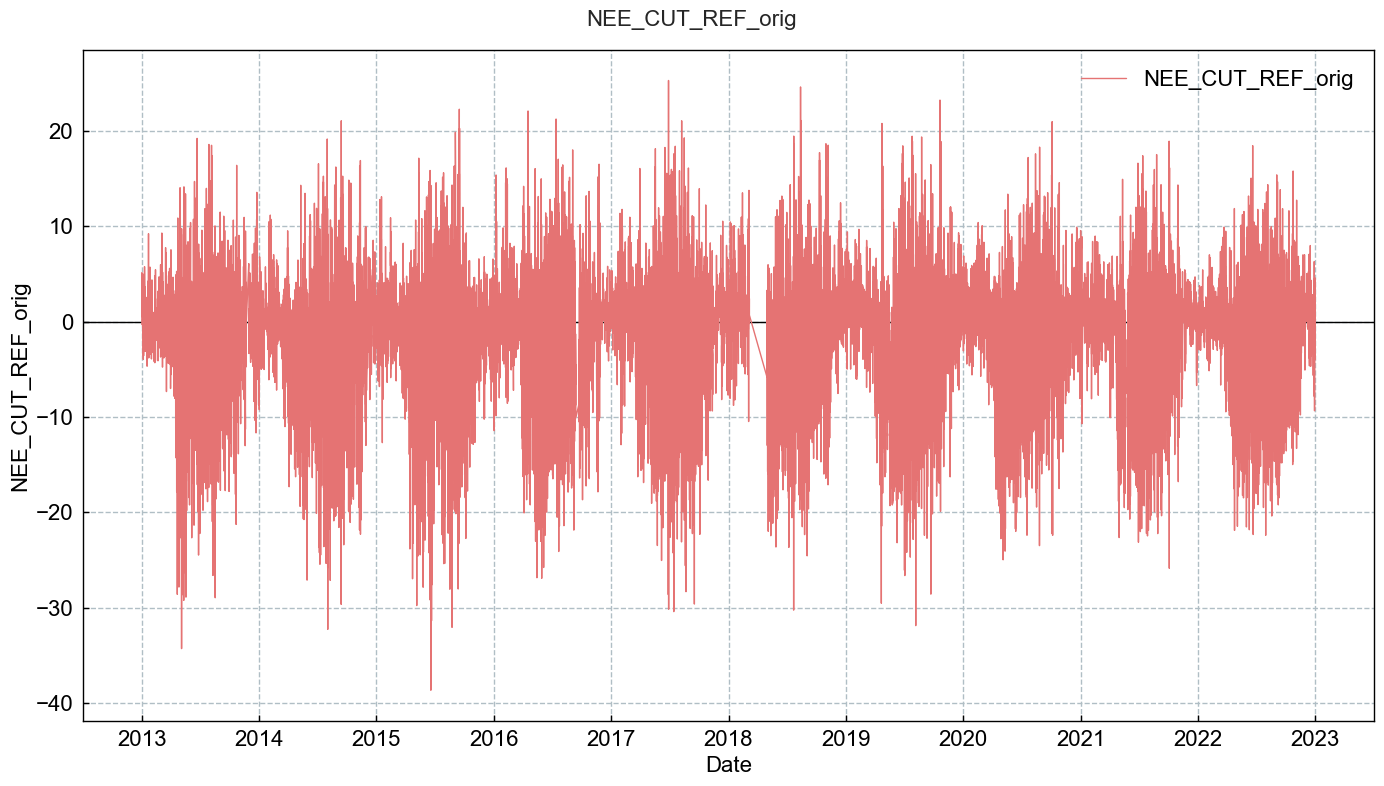

In [10]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Initialize XGBoost

In [11]:
xgbts = XGBoostTS(
        input_df=df,
        target_col=TARGET_COL,
        verbose=1,        
        features_lag=[-1, -1],
        features_lag_exclude_cols=['Rg_f', 'TA>0', 'TA>20', 'DAYTIME', 'NIGHTTIME'],
        include_timestamp_as_features=True,
        add_continuous_record_number=True,
        sanitize_timestamp=True,
        perm_n_repeats=9,
        n_estimators=99,
        random_state=42,
        validate_parameters=True,
        early_stopping_rounds=10,
        max_depth=0,
        learning_rate=0.3,
        tree_method='auto',  # auto, hist, approx, exact
        n_jobs=-1
    )


Creating lagged variants ...
Created lagged variants for: ['Tair_f', 'VPD_f', 'SWC_FF0_0.15_1', 'PPFD'] (lags between -1 and -1 with stepsize 1)
No lagged variants for: ['NEE_CUT_REF_orig', 'Rg_f', 'TA>0', 'TA>20', 'DAYTIME', 'NIGHTTIME']

Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 

Adding continuous record number ...
Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
Sorting timestamp TIMESTAMP_MIDDLE ascending ... Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2013-01-01 00:15:00 and 2022-

</br>

## Feature reduction

In [12]:
xgbts.reduce_features()



Feature reduction based on permutation importance ...
Fitting model <class 'xgboost.sklearn.XGBRegressor'> ...
[0]	validation_0-rmse:4.60413	validation_1-rmse:4.95023
[1]	validation_0-rmse:3.51763	validation_1-rmse:4.27092
[2]	validation_0-rmse:2.70870	validation_1-rmse:3.87439
[3]	validation_0-rmse:2.10275	validation_1-rmse:3.64489
[4]	validation_0-rmse:1.63885	validation_1-rmse:3.51429
[5]	validation_0-rmse:1.28553	validation_1-rmse:3.44607
[6]	validation_0-rmse:1.01346	validation_1-rmse:3.40223
[7]	validation_0-rmse:0.80312	validation_1-rmse:3.37909
[8]	validation_0-rmse:0.63858	validation_1-rmse:3.36550
[9]	validation_0-rmse:0.51036	validation_1-rmse:3.35540
[10]	validation_0-rmse:0.41091	validation_1-rmse:3.34966
[11]	validation_0-rmse:0.33205	validation_1-rmse:3.34717
[12]	validation_0-rmse:0.26963	validation_1-rmse:3.34549
[13]	validation_0-rmse:0.21922	validation_1-rmse:3.34434
[14]	validation_0-rmse:0.17899	validation_1-rmse:3.34369
[15]	validation_0-rmse:0.14659	validation_

In [13]:
xgbts.report_feature_reduction()


FEATURE REDUCTION

- the random variable .RANDOM was added to the original features, used as benchmark for detecting relevant feature importances
- target variable: NEE_CUT_REF_orig
- features before reduction: ['PPFD', 'Rg_f', '.DOY', '.Tair_f-1', 'TA>0', '.HOUR', '.PPFD-1', '.VPD_f-1', 'VPD_f', 'Tair_f', 'TA>20', '.YEARMONTH', '.WEEK', 'SWC_FF0_0.15_1', '.YEARDOY', '.YEARWEEK', '.RECORDNUMBER', '.SWC_FF0_0.15_1-1', '.SEASON', '.YEAR', '.MONTH', 'DAYTIME', '.RANDOM', 'NIGHTTIME']
- permutation importance was calculated from 9 permutations
- These results are from feature reduction. Note that feature importances for the final model are calculated during gap-filling.


PERMUTATION IMPORTANCE (FULL RESULTS):

                   PERM_IMPORTANCE   PERM_SD
PPFD                      0.656127  0.016446
Rg_f                      0.262034  0.007137
.DOY                      0.205513  0.005364
.Tair_f-1                 0.079822  0.003131
TA>0                      0.075373  0.002531
.HOUR       

</br>

## Train model

Building <class 'xgboost.sklearn.XGBRegressor'> model based on data between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...
Fitting model <class 'xgboost.sklearn.XGBRegressor'> ...
[0]	validation_0-rmse:4.60779	validation_1-rmse:4.94281
[1]	validation_0-rmse:3.53071	validation_1-rmse:4.24727
[2]	validation_0-rmse:2.72831	validation_1-rmse:3.84747
[3]	validation_0-rmse:2.12194	validation_1-rmse:3.61265
[4]	validation_0-rmse:1.66128	validation_1-rmse:3.48686
[5]	validation_0-rmse:1.30880	validation_1-rmse:3.41799
[6]	validation_0-rmse:1.03619	validation_1-rmse:3.37837
[7]	validation_0-rmse:0.82462	validation_1-rmse:3.35410
[8]	validation_0-rmse:0.65932	validation_1-rmse:3.34257
[9]	validation_0-rmse:0.52922	validation_1-rmse:3.33494
[10]	validation_0-rmse:0.42775	validation_1-rmse:3.33228
[11]	validation_0-rmse:0.34683	validation_1-rmse:3.32997
[12]	validation_0-rmse:0.28319	validation_1-rmse:3.32962
[13]	validation_0-rmse:0.23220	validation_1-rmse:3.32867
[14]	validation_0-rmse:0.19187	

L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\ml\common.py:608: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


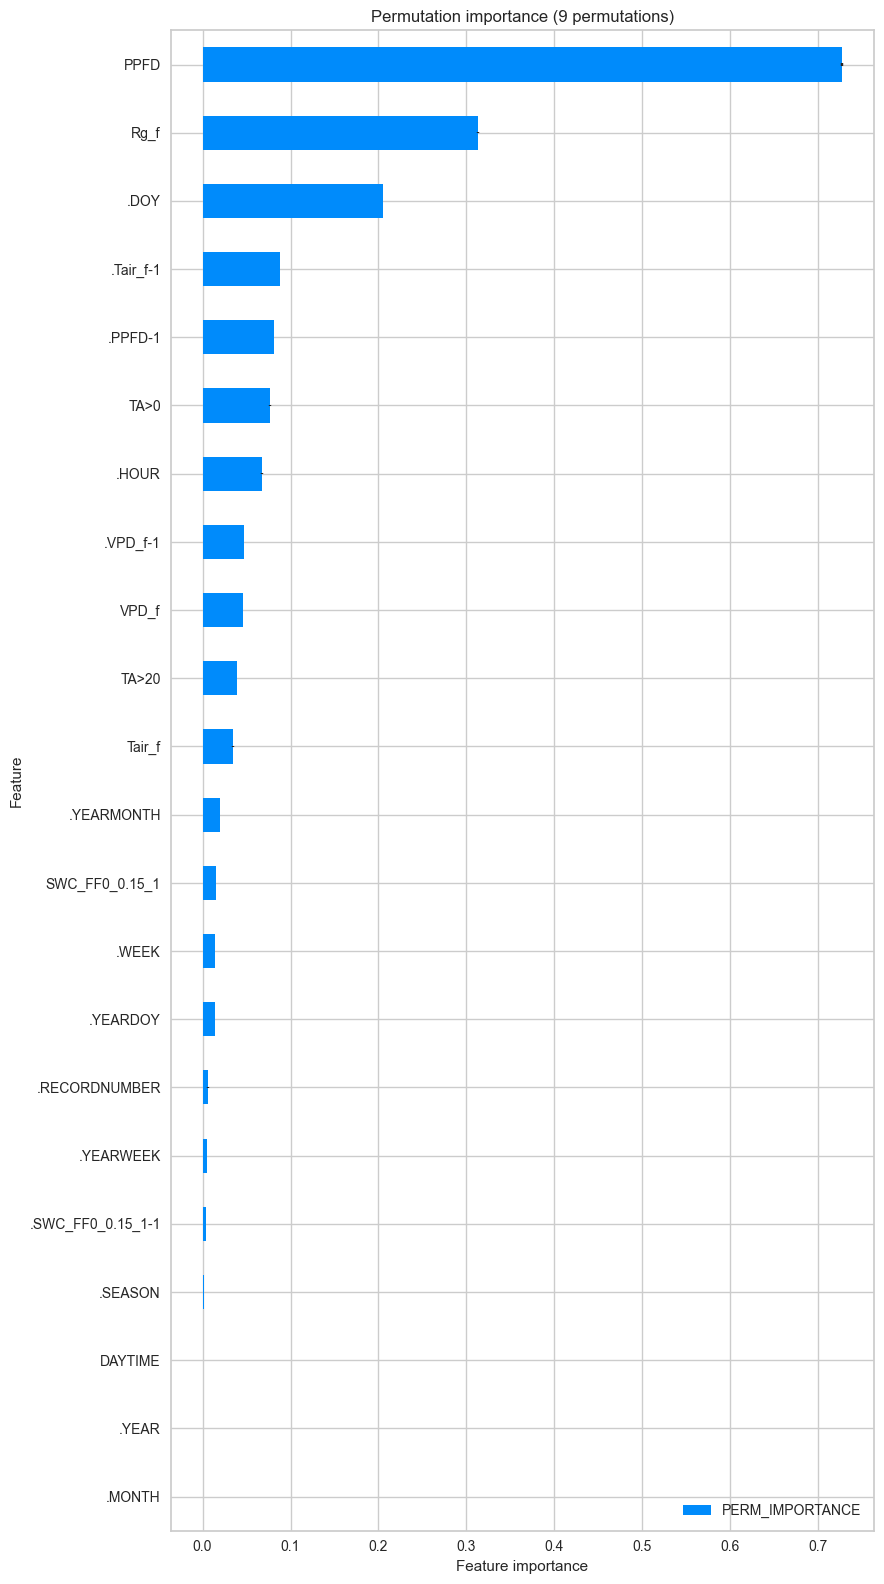

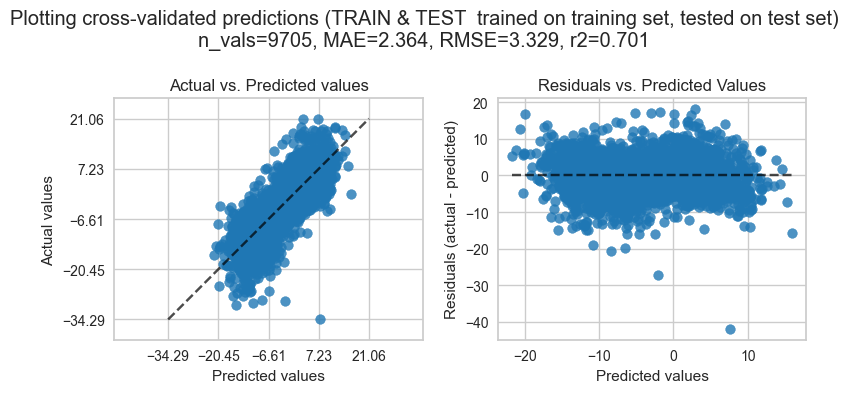

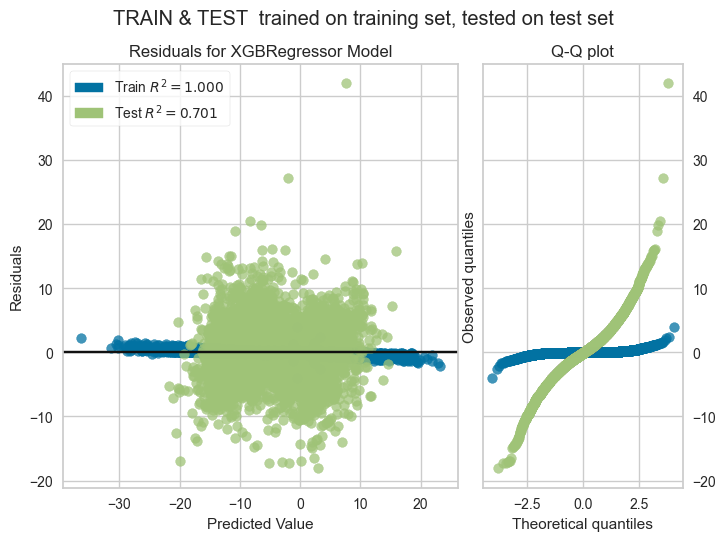

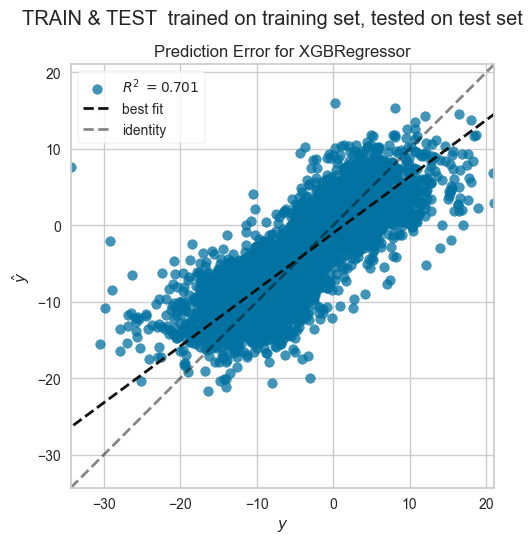

In [14]:
xgbts.trainmodel(showplot_scores=True, showplot_importance=True)

In [15]:
xgbts.report_traintest()


MODEL TRAINING & TESTING RESULTS

- the model was trained and tested based on data between 2013-01-01T01:45:00.000000000 and 2022-12-31T22:15:00.000000000.
- in total, 38820 observed target values were available for training and testing
- the dataset was split into training and test datasets
  > the training dataset comprised 29115 target values (75.0%)
  > the test dataset comprised 9705 target values (25.0%)

## FEATURE IMPORTANCES
- feature importances were calculated for test data (9705 target values).
- permutation importances were calculated from 9 repeats.
                   PERM_IMPORTANCE   PERM_SD
PPFD                      0.726870  0.018808
Rg_f                      0.313242  0.009623
.DOY                      0.204575  0.004805
.Tair_f-1                 0.087559  0.002722
.PPFD-1                   0.080980  0.002913
TA>0                      0.076304  0.002757
.HOUR                     0.067381  0.004399
.VPD_f-1                  0.047683  0.002429
VPD_f                   

</br>

## Apply model to fill gaps

Calculating permutation importance using model <class 'xgboost.sklearn.XGBRegressor'> ...


L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\ml\common.py:608: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


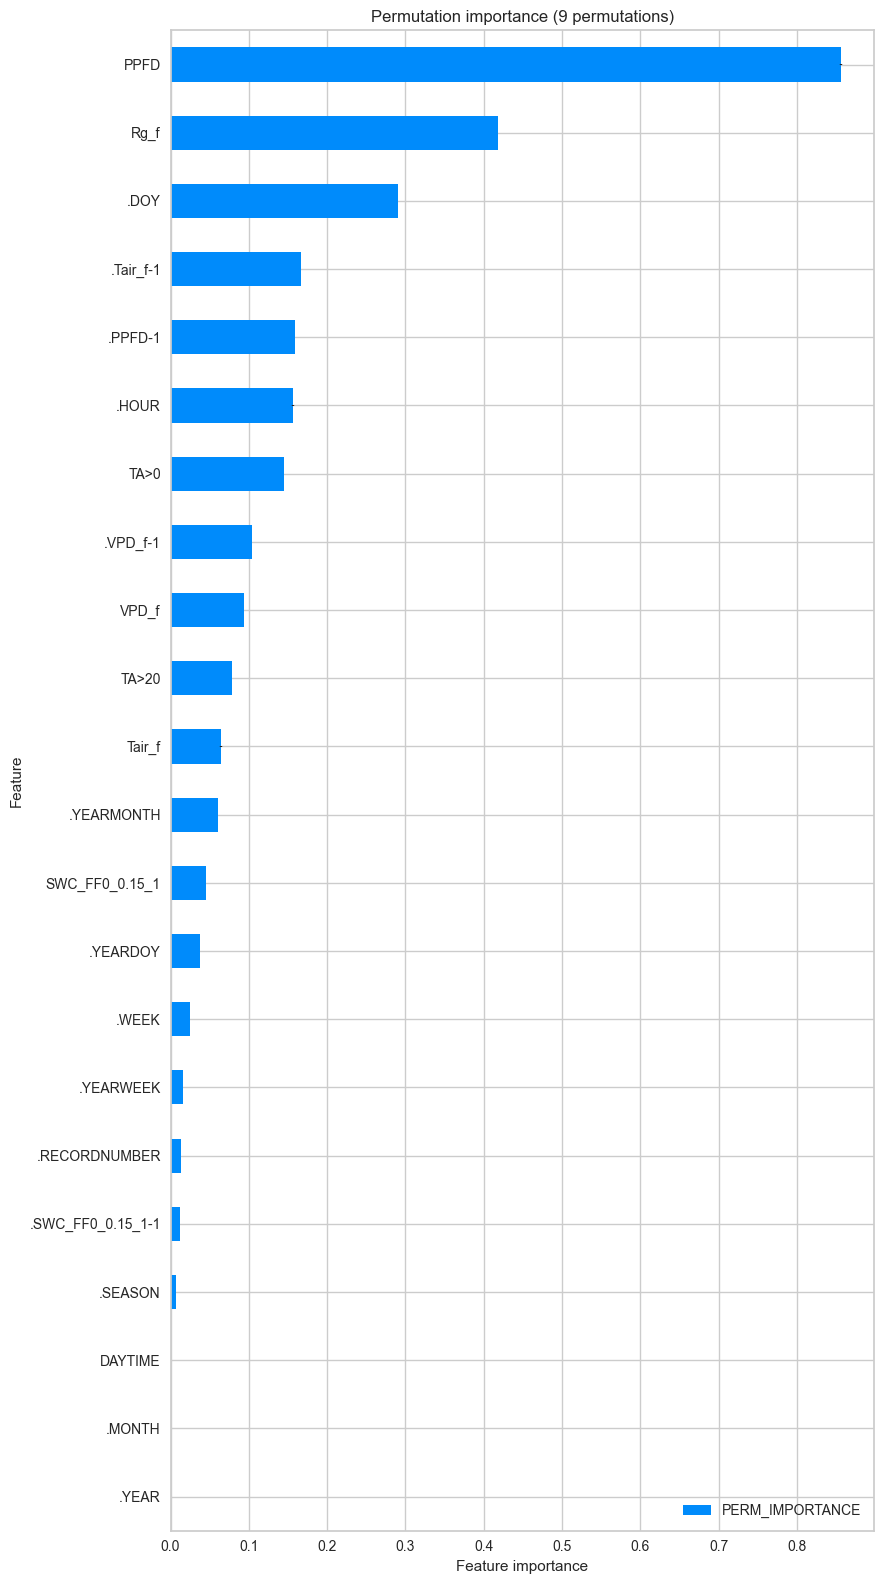

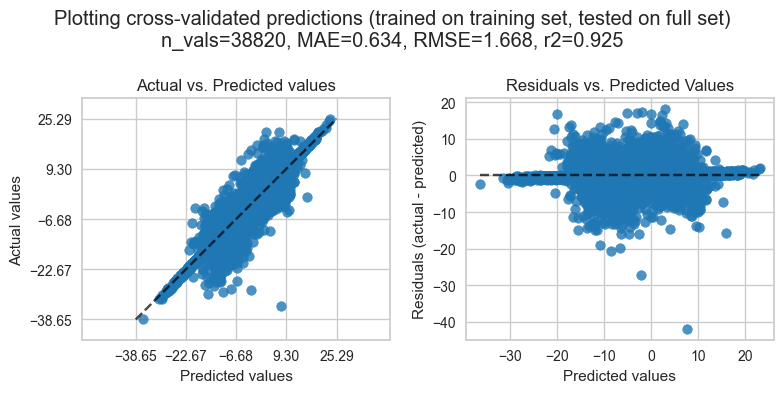


Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] (ONLY FALLBACK)
Fitting model <class 'xgboost.sklearn.XGBRegressor'> ...
[0]	validation_0-rmse:3.86269	validation_1-rmse:3.86269
[1]	validation_0-rmse:3.08741	validation_1-rmse:3.08741
[2]	validation_0-rmse:2.57424	validation_1-rmse:2.57424
[3]	validation_0-rmse:2.23591	validation_1-rmse:2.23591
[4]	validation_0-rmse:2.01524	validation_1-rmse:2.01524
[5]	validation_0-rmse:1.87114	validation_1-rmse:1.87114
[6]	validation_0-rmse:1.77870	validation_1-rmse:1.77870
[7]	validation_0-rmse:1.71968	validation_1-rmse:1.71968
[8]	validation_0-rmse:1.68207	validation_1-rmse:1.68207
[9]	validation_0-rmse:1.65828	validation_1-rmse:1.65828
[10]	validation_0-rmse:1.64305	validation_1-rmse:1.64305
[11]	validation_0-rmse:1.63334	validation_1-rmse:1.63334
[12]	validation_0-rmse:1.62716	validation_1-rmse:1.62716
[13]	validation_0-rmse:1.62324	val

In [16]:
xgbts.fillgaps(showplot_scores=True, showplot_importance=True)

In [17]:
xgbts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (124031 values, NEE_CUT_REF_orig_gfXG where flag=1) in comparison to observed targets (38820 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2013-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 175296 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  136476 (cross-check from flag: 136476)
- target column (gap-filled):  NEE_CUT_REF_orig_gfXG  (175296 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED
  > flag 0 ... observed targets (38820 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (124031 values)
  > flag 2 ... targets gap-filled with fallback (12445 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['PPFD', 'Rg_f', '.DOY', '.Tair_f-1', '.PPFD-1', '.HOUR', 'TA>0', '.VPD_f-1', 'VPD_f', 'TA>20',

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [18]:
xgbts.feature_importances_

,PERM_IMPORTANCE,PERM_SD
PPFD,0.855478,0.008094
Rg_f,0.418334,0.002930
.DOY,0.290443,0.002548
.Tair_f-1,0.167019,0.001806
.PPFD-1,0.159044,0.001105
.HOUR,0.155978,0.001534
TA>0,0.145487,0.001513
.VPD_f-1,0.103784,0.001243
VPD_f,0.093352,0.001234
TA>20,0.079123,0.001186


In [19]:
xgbts.feature_importances_reduction_

,PERM_IMPORTANCE,PERM_SD
PPFD,0.656127,0.016446
Rg_f,0.262034,0.007137
.DOY,0.205513,0.005364
.Tair_f-1,0.079822,0.003131
TA>0,0.075373,0.002531
.HOUR,0.064995,0.002478
.PPFD-1,0.061491,0.002567
.VPD_f-1,0.054092,0.002437
VPD_f,0.047772,0.002639
Tair_f,0.038874,0.002177


In [20]:
xgbts.feature_importances_traintest_

,PERM_IMPORTANCE,PERM_SD
PPFD,0.726870,0.018808
Rg_f,0.313242,0.009623
.DOY,0.204575,0.004805
.Tair_f-1,0.087559,0.002722
.PPFD-1,0.080980,0.002913
TA>0,0.076304,0.002757
.HOUR,0.067381,0.004399
.VPD_f-1,0.047683,0.002429
VPD_f,0.045454,0.003111
TA>20,0.039324,0.002122


In [21]:
xgbts.gapfilling_df_

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED,NEE_CUT_REF_orig_gfXG,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,1.157470,1.157470,1.157470,1.157470
2013-01-01 00:45:00,0.789539,NaN,0.789539,1.0,0.789539,1.157470,1.947009,0.789539
2013-01-01 01:15:00,0.551183,NaN,0.551183,1.0,0.551183,0.529607,2.498192,0.551183
2013-01-01 01:45:00,0.525749,0.538,NaN,0.0,0.538000,0.529607,3.036192,0.525749
2013-01-01 02:15:00,-0.843809,NaN,-0.843809,1.0,-0.843809,0.444580,2.192383,-0.843809
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.489827,NaN,2.489827,1.0,2.489827,1.715796,-84087.062707,2.489827
2022-12-31 22:15:00,3.406610,3.518,NaN,0.0,3.518000,-0.235902,-84083.544707,3.406610
2022-12-31 22:45:00,-1.447790,NaN,-1.447790,1.0,-1.447790,-0.235902,-84084.992497,-1.447790


In [22]:
xgbts.model_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=99, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
xgbts.accepted_features_

['PPFD',
 'Rg_f',
 '.DOY',
 '.Tair_f-1',
 'TA>0',
 '.HOUR',
 '.PPFD-1',
 '.VPD_f-1',
 'VPD_f',
 'Tair_f',
 'TA>20',
 '.YEARMONTH',
 '.WEEK',
 'SWC_FF0_0.15_1',
 '.YEARDOY',
 '.YEARWEEK',
 '.RECORDNUMBER',
 '.SWC_FF0_0.15_1-1',
 '.SEASON',
 '.YEAR',
 '.MONTH',
 'DAYTIME']

In [24]:
xgbts.rejected_features_

['.RANDOM', 'NIGHTTIME']

In [25]:
xgbts.scores_

{'mae': 0.6341149178247157,
 'medae': 0.03867464876174925,
 'mse': 2.7830741571859714,
 'rmse': 1.6682548238161852,
 'mape': 29360822080.99505,
 'maxe': 41.95621384429931,
 'r2': 0.9250428712721172}

In [26]:
xgbts.scores_test_

{'mae': 2.3642436843089984,
 'medae': 1.6848809967041012,
 'mse': 11.079039586807092,
 'rmse': 3.3285191282020734,
 'mape': 90256318903.55498,
 'maxe': 41.95621384429931,
 'r2': 0.7011042445986557}

In [27]:
xgbts.traintest_details_.keys()

dict_keys(['X', 'y', 'timestamp', 'predictions', 'X_names', 'y_name', 'X_train', 'y_train', 'X_test', 'y_test', 'model'])

</br>

## Result

In [28]:
gapfilled = xgbts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    1.157470
2013-01-01 00:45:00    0.789539
2013-01-01 01:15:00    0.551183
2013-01-01 01:45:00    0.538000
2013-01-01 02:15:00   -0.843809
                         ...   
2022-12-31 21:45:00    2.489827
2022-12-31 22:15:00    3.518000
2022-12-31 22:45:00   -1.447790
2022-12-31 23:15:00   -1.790129
2022-12-31 23:45:00   -0.509094
Freq: 30min, Name: NEE_CUT_REF_orig_gfXG, Length: 175296, dtype: float64

In [29]:
flag = xgbts.get_flag()
flag

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    2.0
2013-01-01 00:45:00    1.0
2013-01-01 01:15:00    1.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    1.0
                      ... 
2022-12-31 21:45:00    1.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    1.0
2022-12-31 23:15:00    1.0
2022-12-31 23:45:00    1.0
Freq: 30min, Name: FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED, Length: 175296, dtype: float64

In [30]:
gapfilling_df = xgbts.gapfilling_df_
gapfilling_df

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfXG_ISFILLED,NEE_CUT_REF_orig_gfXG,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,1.157470,1.157470,1.157470,1.157470
2013-01-01 00:45:00,0.789539,NaN,0.789539,1.0,0.789539,1.157470,1.947009,0.789539
2013-01-01 01:15:00,0.551183,NaN,0.551183,1.0,0.551183,0.529607,2.498192,0.551183
2013-01-01 01:45:00,0.525749,0.538,NaN,0.0,0.538000,0.529607,3.036192,0.525749
2013-01-01 02:15:00,-0.843809,NaN,-0.843809,1.0,-0.843809,0.444580,2.192383,-0.843809
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.489827,NaN,2.489827,1.0,2.489827,1.715796,-84087.062707,2.489827
2022-12-31 22:15:00,3.406610,3.518,NaN,0.0,3.518000,-0.235902,-84083.544707,3.406610
2022-12-31 22:45:00,-1.447790,NaN,-1.447790,1.0,-1.447790,-0.235902,-84084.992497,-1.447790


</br>

## Plot

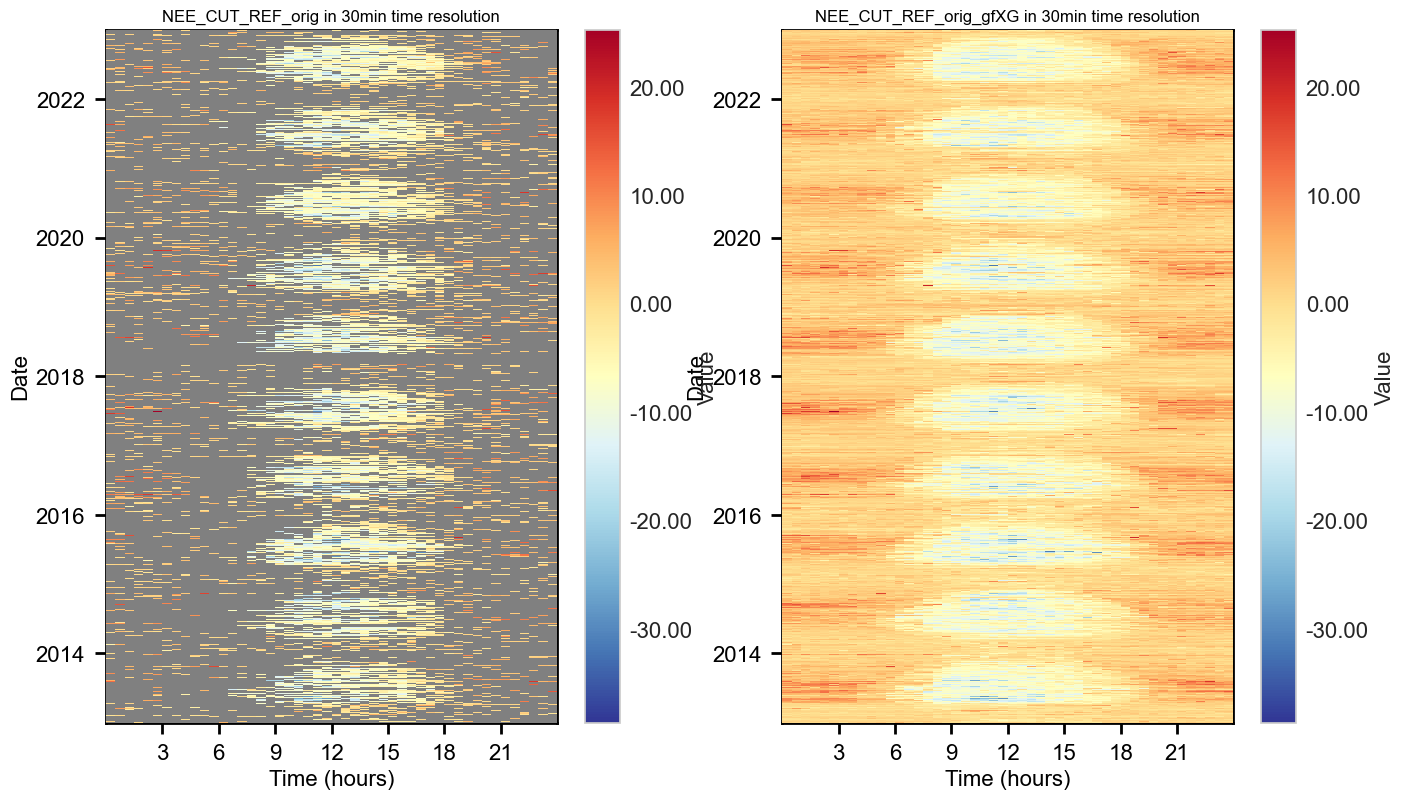

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


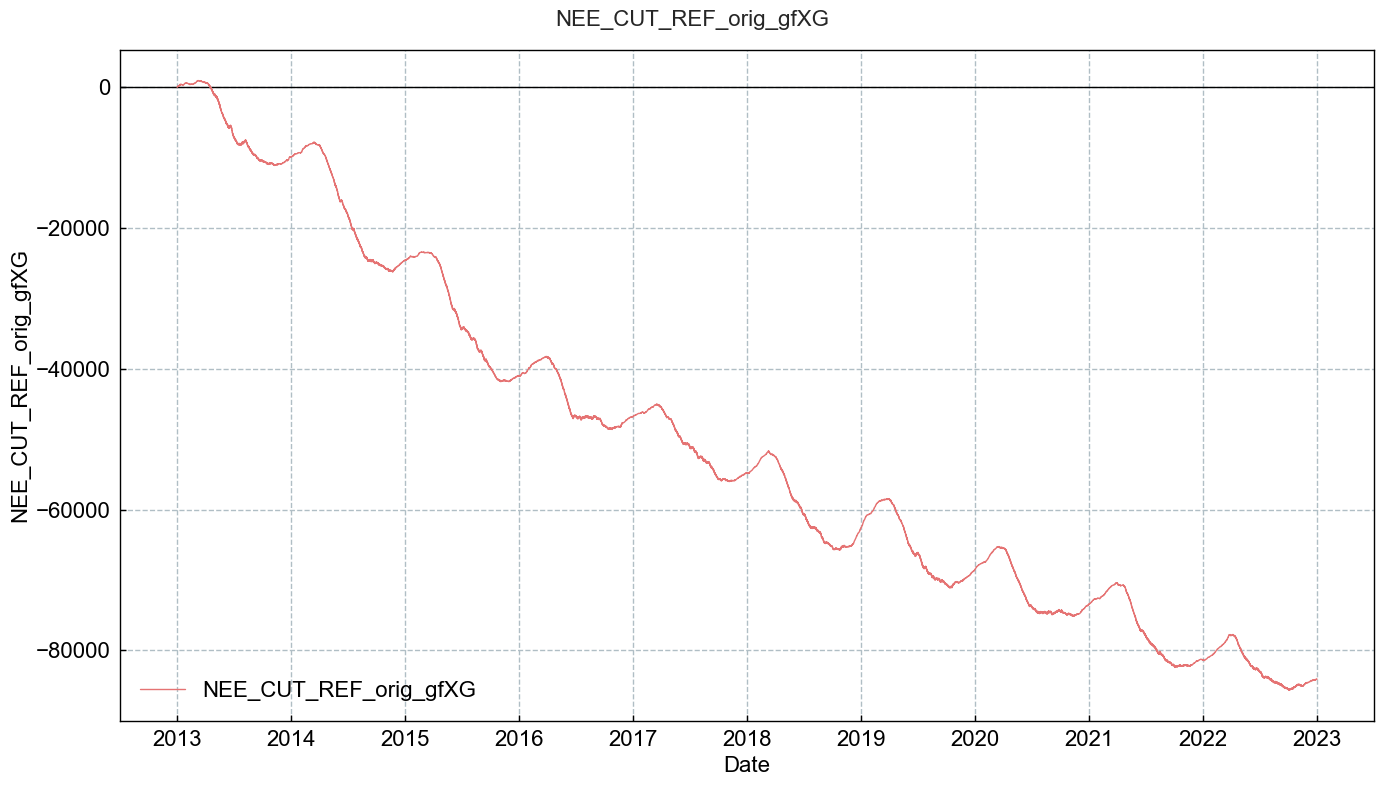

In [32]:
TimeSeries(gapfilled.cumsum()).plot();

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [33]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-04-26 13:14:21
